# About
Replication is important! In this notebook, I try to reproduce [strangely stunted trees's results](https://metatalk.metafilter.com/24387/Visualizing-the-impact-of-US-politics-megaposts-on-the-blue)

# Key Findings
We want to show that:
1. More comments on the frontpage ("the blue") are in the MegaThreads than are not
2. Fewer posts are being made
3. Fewer users are commenting

# Setup
Here we load the data store and set up a list of political tags as defined in the original post.

In [1]:
%matplotlib inline
import datetime as dt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from helpers import daily_rolling_avg_count

sns.set_context('notebook')

DATA_DIR = os.path.join('..', '..', 'data')

politics_tags = set(['election2016', 'election',
                     'potus45', 'DonaldTrump',
                     'BarackObama', 'obama',
                     'trump', 'hillaryclinton',
                     'BernieSanders', 'Clinton',
                     'sanders', 'USPolitics'])

# In the original analysis, sst didn't lowercase the tags.
# We do that here just to try to catch any missing threads.
politics_tags_lower = set(x.lower() for x in politics_tags)

store = pd.HDFStore(os.path.join(DATA_DIR, 'infodump.h5'))

# Work
## More comments on the frontpage are in the MegaThreads than are not
sst posits that "[d]uring the period from July of 2016 through February 2017, politics megathreads actually have more comments than all other posts combined, an average of 713 comments a day within megaposts and 702 a day in all other threads."

### Work

In [2]:
tag_df = store['/mefi/tagdata'].loc[:, ['link_id', 'tag_name']]
politics_threads = tag_df.loc[tag_df.tag_name.isin(politics_tags),
                              'link_id'].\
                          unique()
print('{} politics threads'.format(len(politics_threads)))
        
lower_politics_threads = tag_df.loc[tag_df.tag_name.str.lower().isin(politics_tags_lower),
                                    'link_id'].\
                                unique()
print('{} politics threads when tags are lowercased'.format(len(lower_politics_threads)))

1761 politics threads
2234 politics threads when tags are lowercased


In [3]:
post_df = store['/mefi/postdata'].loc[:, ['postid', 'datestamp', 'comments']]
post_df = post_df.loc[(post_df.datestamp > dt.datetime(2012, 12, 31)) &
                      (post_df.datestamp < dt.datetime(2017, 5, 1)), :]

post_df['political_mega'] = post_df.postid.isin(politics_threads) & (post_df.comments >= 500)
print('{} political MegaThreads with {} comments'.format(post_df.political_mega.sum(),
                                                        post_df.loc[post_df.political_mega == True,
                                                                    'comments'].sum()))

post_df['lower_political_mega'] = post_df.postid.isin(lower_politics_threads) & (post_df.comments >= 500)
print('{} lower political MegaThreads with {} comments'.format(post_df.lower_political_mega.sum(),
                                                              post_df.loc[post_df.lower_political_mega == True,
                                                                          'comments'].sum()))

98 political MegaThreads with 252021 comments
98 lower political MegaThreads with 252021 comments


In [4]:
post_df.loc[post_df.political_mega == True, ['datestamp', 'comments']].\
                    groupby(pd.Grouper(key='datestamp', freq='1D')).\
                    sum().\
                    describe()

,comments
count,97.000000
mean,2598.154639
std,1131.547551
min,506.000000
25%,1681.000000
50%,2724.000000
75%,3377.000000
max,5922.000000


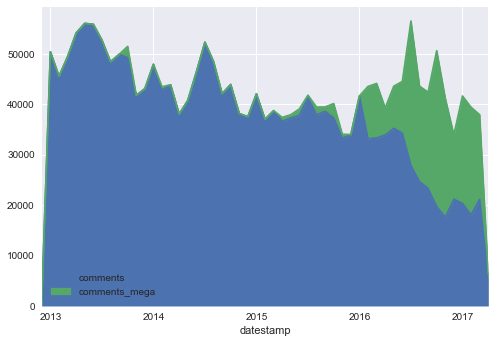

In [5]:
non_mega_df = post_df.loc[post_df.political_mega == False, ['datestamp', 'comments']].\
                      groupby(pd.Grouper(key='datestamp', freq='1M')).\
                      sum()

mega_df = post_df.loc[post_df.political_mega == True, ['datestamp', 'comments']].\
                  groupby(pd.Grouper(key='datestamp', freq='1M')).\
                  sum()

non_mega_df.join(mega_df, how='outer', rsuffix='_mega').\
            fillna(0).\
            plot(kind='area')

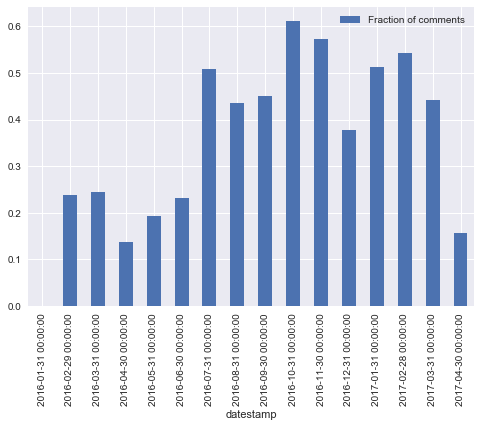

In [6]:
# Let's look at the proportion of comments per month in MegaThreads since 2016
frac_df = mega_df.div((mega_df + non_mega_df)).\
                  fillna(0).\
                  reset_index().\
                  rename(columns={'comments': 'Fraction of comments'})

frac_df.loc[(frac_df.datestamp >= dt.datetime(2016, 1, 1)), :].\
        set_index('datestamp').\
        plot(kind='bar')

In [7]:
# Let's get the average number of comments per day in each of the threads during the target period.
# This actually requires us to turn to the comment data.
# ...

### Discussion
By my count the comments in political MegaThreads took up more than half of the front-page's comment volume during five non-consecutive months. Not quite as much as originally reported, but still very high.

## Fewer posts are being made

### Work

In [8]:
post_df = store['/mefi/postdata'].loc[:, ['postid', 'datestamp']]
post_df = post_df.loc[(post_df.datestamp > dt.datetime(1999, 1, 1)) &
                      (post_df.datestamp < dt.datetime(2017, 5, 1)), :]

print(post_df.shape)
post_df.head()

(165366, 2)


,postid,datestamp
0,19,1999-07-14 15:03:04.930
1,25,1999-07-15 09:37:51.770
2,26,1999-07-15 09:54:26.280
3,27,1999-07-15 09:57:54.160
4,33,1999-07-15 11:18:45.247


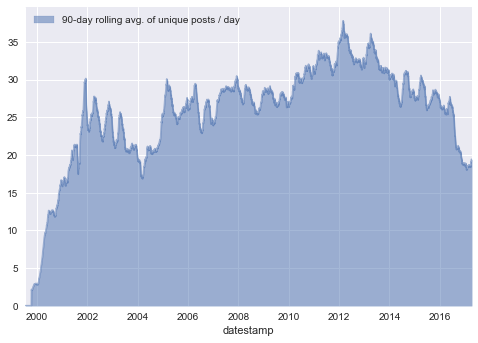

In [9]:
# getting and plotting the rolling average of the number of posts per day
# over a ninety day period
post_df.groupby(pd.Grouper(key='datestamp', freq='1D')).\
        count().\
        fillna(0).\
        rolling(90).\
        mean().\
        rename(columns={'postid': '90-day rolling avg. of unique posts / day'}).\
        plot(kind='area', stacked=False)

### Discussion

## Fewer users are commenting

### Work

In [10]:
# get comment data
comment_user_df = store['/mefi/commentdata'].loc[:, ['userid', 'datestamp']]
comment_user_df = comment_user_df.loc[(comment_user_df.datestamp > dt.datetime(1999, 1, 1)), :]

print(comment_user_df.shape)
comment_user_df.head()

(6927065, 2)


,userid,datestamp
0,1,1999-07-15 01:21:06.213
1,1,1999-07-15 10:00:12.850
2,16,1999-07-15 10:04:48.563
3,16,1999-07-15 10:54:36.160
4,1,1999-07-15 12:04:04.867


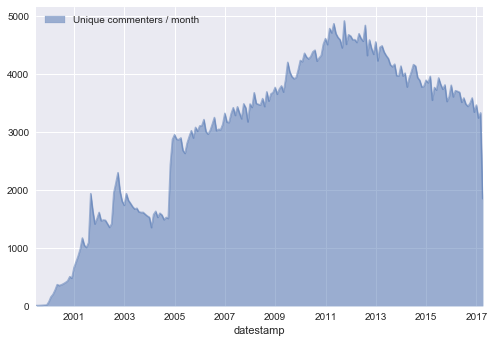

In [11]:
# getting and plotting the number of distinct commenters per month
comment_user_df.loc[comment_user_df.datestamp < dt.datetime(2017, 5, 1), :].\
                groupby(pd.Grouper(key='datestamp', freq='1M')).\
                agg(lambda x: x.nunique()).\
                fillna(0).\
                rename(columns={'userid': 'Unique commenters / month'}).\
                plot(kind='area', stacked=False)

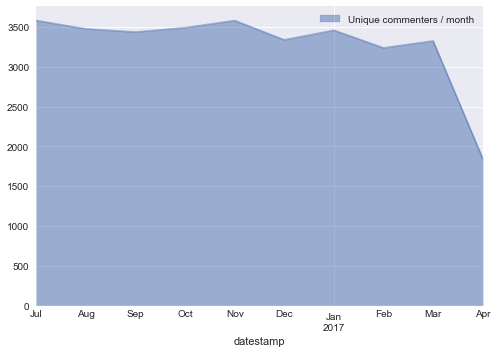

In [12]:
# Looking a little bit more clostely at the weird fall off at the end of April
comment_user_df.loc[(comment_user_df.datestamp > dt.datetime(2016, 7, 1)) &
                    (comment_user_df.datestamp < dt.datetime(2017, 5, 1)), :].\
                groupby(pd.Grouper(key='datestamp', freq='1M')).\
                agg(lambda x: x.nunique()).\
                fillna(0).\
                rename(columns={'userid': 'Unique commenters / month'}).\
                plot(kind='area', stacked=False)

In [13]:
# Looking at the weird drop-off as a table
comment_user_df.loc[(comment_user_df.datestamp > dt.datetime(2016, 7, 1)) &
                    (comment_user_df.datestamp < dt.datetime(2017, 5, 1)), :].\
                groupby(pd.Grouper(key='datestamp', freq='1M')).\
                agg(lambda x: x.nunique()).\
                fillna(0).\
                reset_index().\
                tail(5)

,datestamp,userid
5,2016-12-31,3338
6,2017-01-31,3459
7,2017-02-28,3237
8,2017-03-31,3325
9,2017-04-30,1847


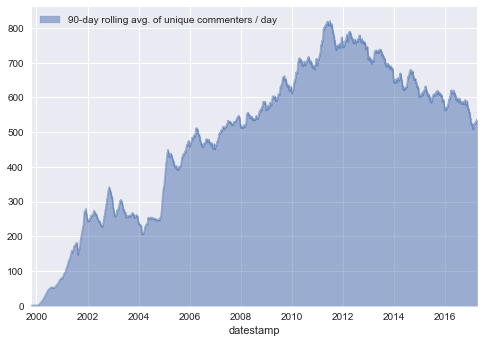

In [14]:
# Getting the rolling average of the number of commenters per ninety-day period
comment_user_df.loc[comment_user_df.datestamp < dt.datetime(2017, 5, 1), :].\
                groupby(pd.Grouper(key='datestamp', freq='1D')).\
                agg(lambda x: x.nunique()).\
                fillna(0).\
                rolling(90).\
                mean().\
                dropna().\
                rename(columns={'userid': '90-day rolling avg. of unique commenters / day'}).\
                plot(kind='area', stacked=False)

### Discussion
The number of distinct monthly front-page commenters has indeed been declining since 2012, though visuaully it seems hard to tie that to the election. The drop-off during April, 2017 has been surprisingly steep, and perhaps bears further investigation.